# Modis Vegetation Index 

This week, we will work with MODIS data, which is one of the most commonly satellite data products, because it covers the entire globe almost every day and because is freely available from NASA.

There is a plethora of MODIS products for many environmental applications including wildfire detection, evapotranspiration, and land surface temperature. [Here](https://ladsweb.modaps.eosdis.nasa.gov/#land) is an overview about the different land surface products. 

The MODIS spatial resolution is 250 m, which is high enough resolution to see local variability. There are sensors with much higher resolution, but they cannot cover the globe every day. So if we want to understand day to day changes, MODIS is a good start. 


Below is an example of a daily MODIS scene over Boulder, CO. 

<img src='https://i.pinimg.com/originals/7a/48/83/7a4883e6ade765666a9a4db2911817bb.jpg' width='300'>

As you can see, there are many clouds, which MODIS cannot see through. It is therefore necessary to aggregate MODIS scenes from several days to get a complete picture.  

Common MODIS products are aggregated to 8 or 16 day resolutions to minimize issues with clouds. Also, because there are two MODIS sensors on the AQUA and TERRA satellites, which pass over Earth at different times, it is possible to combine the two for more data. 

As an example for this week, we will look into vegetation indices such as the Normalized Difference Vegetation Index (NDVI), which essentially is a measure of vegetation green-ness and can therefore be used to detect seasonal changes in vegetation or even drought. To reduce the amount of data and the computational time, we are using a monthly product that has been downscaled to 10 km x 10 km resolution.

The MODIS Vegetation Index products are described [here](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/science-domain/vegetation-indices/).

In [1]:
# Import the tools we are going to need today:
import matplotlib.pyplot as plt  # plotting library
import numpy as np  # numerical library
import xarray as xr  # netCDF library
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
import glob

ModuleNotFoundError: No module named 'matplotlib'

## Loading the dataset

Using `glob` to look inside our data folder, we can see that our dataset consists of several files, each corresponding to a year of data. 
This is quite common as climate data files can be very big. For example, each of the non-downscaled files is roughly 2GB. Downsampling from 1 km to 10 km reduces this by a factor of 100. 

In [2]:
files = glob.glob(r'../data/*latlon_*10km.nc')
files

['../data\\MOD13A3.061_1km_aid0001_latlon_2020_10km.nc',
 '../data\\MOD13A3.061_1km_aid0001_latlon_2021_10km.nc',
 '../data\\MOD13A3.061_1km_aid0001_latlon_2022_10km.nc',
 '../data\\MOD13A3.061_1km_aid0001_latlon_2023_10km.nc',
 '../data\\MOD16A2GF.061_500m_aid0001_latlon_2020_10km.nc',
 '../data\\MOD16A2GF.061_500m_aid0001_latlon_2021_10km.nc',
 '../data\\MOD16A2GF.061_500m_aid0001_latlon_2022_10km.nc',
 '../data\\MOD16A2GF.061_500m_aid0001_latlon_2023_10km.nc']

Let's check out a one of these files to see what is in them. 

In [3]:
xr.open_dataset('../data\\MOD13A3.061_1km_aid0001_latlon_2022_10km.nc')

<xarray.Dataset>
Dimensions:                               (time: 12, lat: 357, lon: 790)
Coordinates:
  * time                                  (time) object 2022-01-01 00:00:00 ....
  * lat                                   (lat) float64 50.81 50.72 ... 21.14
  * lon                                   (lon) float64 -128.9 -128.8 ... -63.13
Data variables:
    crs                                   int8 ...
    _1_km_monthly_EVI                     (time, lat, lon) float32 ...
    _1_km_monthly_MIR_reflectance         (time, lat, lon) float32 ...
    _1_km_monthly_NDVI                    (time, lat, lon) float32 ...
    _1_km_monthly_NIR_reflectance         (time, lat, lon) float32 ...
    _1_km_monthly_VI_Quality              (time, lat, lon) float64 ...
    _1_km_monthly_blue_reflectance        (time, lat, lon) float32 ...
    _1_km_monthly_pixel_reliability       (time, lat, lon) float64 ...
    _1_km_monthly_red_reflectance         (time, lat, lon) float32 ...
    _1_km_monthly_relative_azimuth_angle  (time, lat, lon) float32 ...
    _1_km_monthly_sun_zenith_angle        (time, lat, lon) float32 ...
    _1_km_monthly_view_zenith_angle       (time, lat, lon) float32 ...
Attributes:
    title:        MOD13A3.061 for aid0001
    Conventions:  CF-1.6
    institution:  Land Processes Distributed Active Archive Center (LP DAAC)
    source:       AppEEARS v3.48
    references:   See README.md
    history:      See README.md

## Opening a dataset containing multiple files. 

Because datasets with multiple files are quite common, xarray can process these using the `xr.open_mfdataset()` command, for multiple files. Because xarray is used to big data, it will not actually read the contents of the file into your computer's memory, but will make note, where things are stored and then access them if needed. 

This makes working with dataset sizes that exceed your RAM possible.

_Note: xr.open_mfdataset() requires that `dask` is installed. I have added it to the computing environment. If you still need to install it, this is best done from the command line._ 

In [4]:
ds = xr.open_mfdataset(r'../data/*latlon_*10km.nc')
ds['time']=ds.indexes['time'].to_datetimeindex() # Xarray has a small problem with the time index in the original form. This fixes it.  
ds

C:\Users\jessr\AppData\Local\Temp\ipykernel_5036\1480904751.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds['time']=ds.indexes['time'].to_datetimeindex() # Xarray has a small problem with the time index in the original form. This fixes it.


<xarray.Dataset>
Dimensions:                               (time: 209, lat: 714, lon: 810)
Coordinates:
  * time                                  (time) datetime64[ns] 2019-12-27 .....
  * lat                                   (lat) float64 21.14 21.14 ... 50.81
  * lon                                   (lon) float64 -128.9 -128.8 ... -63.13
Data variables: (12/17)
    crs                                   (time) float32 -127.0 ... -127.0
    ET_500m                               (time, lat, lon) float32 dask.array<chunksize=(53, 714, 810), meta=np.ndarray>
    ET_QC_500m                            (time, lat, lon) float32 dask.array<chunksize=(53, 714, 810), meta=np.ndarray>
    LE_500m                               (time, lat, lon) float32 dask.array<chunksize=(53, 714, 810), meta=np.ndarray>
    PET_500m                              (time, lat, lon) float32 dask.array<chunksize=(53, 714, 810), meta=np.ndarray>
    PLE_500m                              (time, lat, lon) float32 dask.array<chunksize=(53, 714, 810), meta=np.ndarray>
    ...                                    ...
    _1_km_monthly_blue_reflectance        (time, lat, lon) float32 dask.array<chunksize=(54, 714, 810), meta=np.ndarray>
    _1_km_monthly_pixel_reliability       (time, lat, lon) float64 dask.array<chunksize=(54, 714, 810), meta=np.ndarray>
    _1_km_monthly_red_reflectance         (time, lat, lon) float32 dask.array<chunksize=(54, 714, 810), meta=np.ndarray>
    _1_km_monthly_relative_azimuth_angle  (time, lat, lon) float32 dask.array<chunksize=(54, 714, 810), meta=np.ndarray>
    _1_km_monthly_sun_zenith_angle        (time, lat, lon) float32 dask.array<chunksize=(54, 714, 810), meta=np.ndarray>
    _1_km_monthly_view_zenith_angle       (time, lat, lon) float32 dask.array<chunksize=(54, 714, 810), meta=np.ndarray>
Attributes:
    title:        MOD16A2GF.061 for aid0001
    Conventions:  CF-1.6
    institution:  Land Processes Distributed Active Archive Center (LP DAAC)
    source:       AppEEARS v3.48
    references:   See README.md
    history:      See README.md

We can now see that the loaded multiple file dateset has 4 years of data, like we would expect. 

## Plot NDVI

Let's begin by plotting NDVI, which has the variable name `'_1_km_monthly_NDVI'`.

In [11]:
#Select ndvi
NDVI = ds['_1_km_monthly_NDVI']

The plot below is quite complicated and makes use of the fact that xarray create subplots. Try to understand what each line does, by for example commenting it out. 

A good guide to plotting in xarray is found [here](https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Beginners_guide/04_Plotting.html).

The basic structure of the plot is taken from the [xarray visualization example gallery](https://docs.xarray.dev/en/stable/examples/visualization_gallery.html)

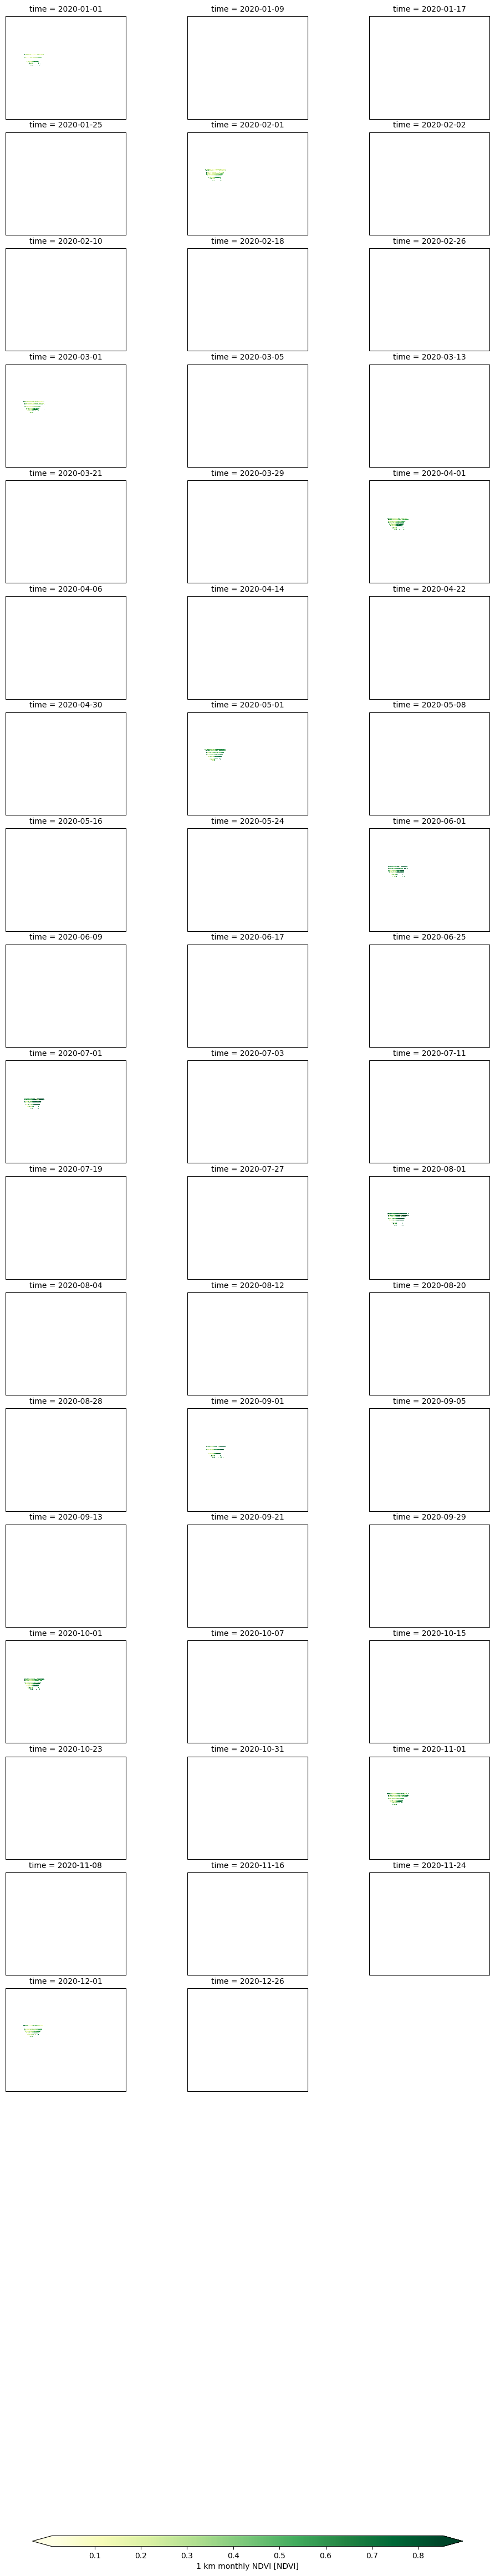

In [12]:
# plot
# This time we are 
fig = NDVI.sel(time=slice('2020-01-01','2020-12-31')).plot(
    col="time", # we tell xarray to make a plot for each time and to put that into columns
    col_wrap = 3, # and to start a new row after 3 plots. 
    transform=ccrs.PlateCarree(),  # remember to provide this!
    subplot_kws={"projection": ccrs.Mercator()},
    cmap='YlGn', # This is the colormap going from yellow to green. 
    robust=True, # This removes some extreme values 
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40}, # this sets the orientation and size of the colorbar.
)
    

## Diving a bit deeper into NDVI

Because the chlorohyll plant leaves absorb visible red light for use in photosynthesis and reflect near infrared light (NIR), we use the NDVI as a measure of how much green vegetation there is. It can be calculated as: 

$NDVI = \frac{NIR - Red}{NIR + Red}$


The _MODIS Vegetation Indices_ product that we downloaded not only contains calculated _NDVI_ and _EVI_ but the MODIS bands from which they were calcuated. 

Let's check whether we can reproduce the _NDVI_ product from its components. 

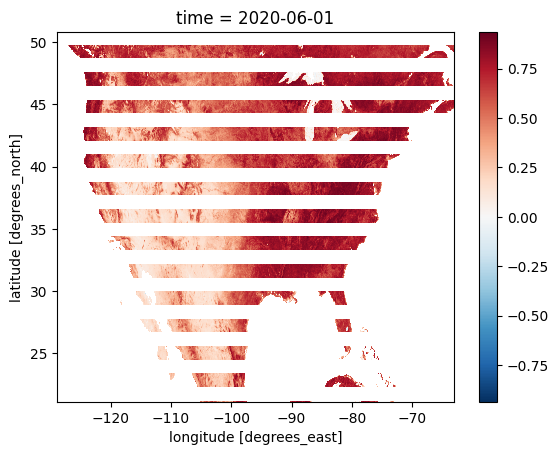

In [69]:
NIR = ds['_1_km_monthly_NIR_reflectance'].sel(time = '2020-06-01')
red = ds['_1_km_monthly_red_reflectance'].sel(time = '2020-06-01')
OurNDVI = (NIR - red) / (NIR + red)

# unprojected plot to check
OurNDVI.plot()

How about we compare our calculated NDVI with the NDVI in the files

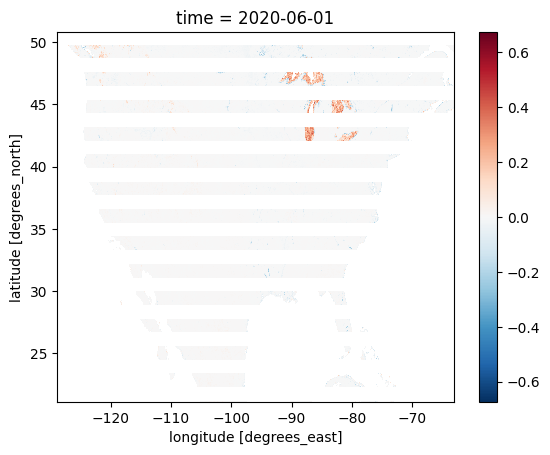

In [70]:
NDVI_difference = NDVI.sel(time = '2020-06-01')-OurNDVI
NDVI_difference.plot()

**Overall, there seems to be good agreement, except when there is water, where NDVI is not valid anyways.**

## Analysing the NDVI annual cycle

I downloaded four years of NDVI data and when take the average over our domain, we can clearly see that there is an annual cycle. 

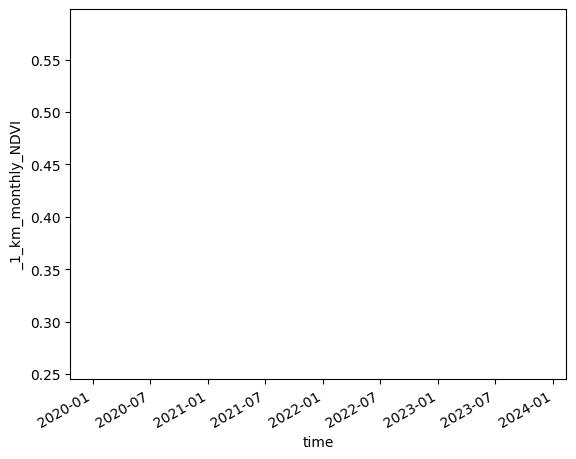

In [71]:
NDVI.mean(dim=['lon','lat']).plot()

Because almost all climate related data has annual cycles, it can be quite difficult to find trends or even see when things are a bit unusual. For example, the impact of a drought on _NDVI_ will be much smaller than the typical difference between winter and summer. 

One solution to this problem is to calculate anomalies. 

This means, we calculate the average annual cycle and then substract that from our data. 
_Note: In climate science, one typically aims for 30-year averages, but here we have to do with 4 years._

### Calculating the mean annual cycle using groupings

The first step is to split the data into groups based on month. 

Xarray also offers a more concise syntax when the variable you’re grouping on is already present in the dataset. 

In [72]:
NDVI.groupby("time.month")

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

Now that we have groups defined, it’s time to “apply” a calculation to the group. These calculations can either be:
-   aggregation: reduces the size of the group-     transformation: preserves the group’s full size

At then end of the apply step, xarray will automatically combine the aggregated/transformed groups back into a single o

Let’s calculate the climatology at every point in the dataset. To do so, we will use aggregation and will calculate the mean NDVI for each month:

The result gives us the mean annual cylce: bject.

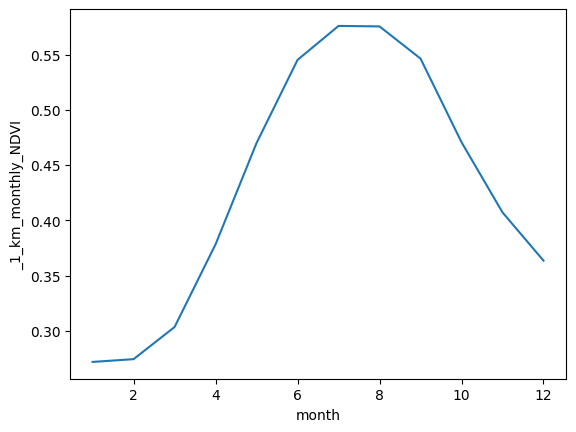

In [73]:
NDVI_climatology = NDVI.groupby("time.month").mean("time")
NDVI_climatology.mean(dim=['lon','lat']).plot()

We’ll compute the climatology using xarray’s groupby operation to split the NDVI data by month. Then, we’ll remove this climatology from our original data to find the anomaly:
tos_anom


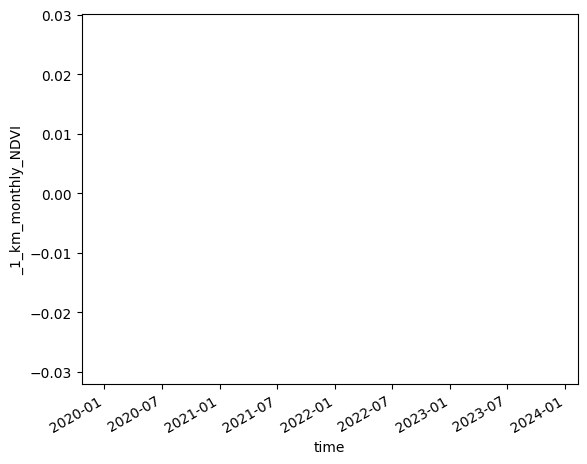

In [74]:
# group all data by month
gb = NDVI.groupby("time.month")

# subtract this mean from all data of the same month
NDVI_anomaly = gb - NDVI_climatology
NDVI_anomaly.mean(dim=['lon','lat']).plot()


## Using NDVI to investigate drought

Droughts are defined as periods of drier than normal conditions and often have large impacts on ecosystems and agriculture. Because drought causes plant stress and wilting _NDVI_, which is effectively a measure of plant greeness, is commonly used to diagnose drought impacts. 

The central U.S. and particularly Kansas, were affected by ***Exceptional Drought*** in Spring of 2023.  
<img src='https://droughtmonitor.unl.edu/data/png/20230418/20230418_usdm.png' width='600'>

[US Drought Monitor](https://droughtmonitor.unl.edu/Maps/MapArchive.aspx)

The same period in 2020 was without drought:   
<img src='https://droughtmonitor.unl.edu/data/png/20200414/20200414_usdm.png' width='600'>

[US Drought Monitor](https://droughtmonitor.unl.edu/Maps/MapArchive.aspx)


For the next part of the analysis, we will focus on Kansas. If we were to draw a box around Kansas, which is easy since Kansas is practically a rectangle, it would have the following coordinates.

In [75]:
Kansas =[ -102.052894,36.992751,-94.590752,40.002896]

Let's see how the NDVI values compare. We can use a histogram for that.

In [78]:
fig = plt.figure()
ds._1_km_monthly_NDVI.sel(time='2020-04-01',lat=slice(Kansas[3], Kansas[1]),lon=slice(Kansas[0], Kansas[2])).plot.hist(bins=20, alpha=0.5)
ds._1_km_monthly_NDVI.sel(time='2023-04-01',lat=slice(Kansas[3], Kansas[1]),lon=slice(Kansas[0], Kansas[2])).plot.hist(bins=20, alpha=0.5)
plt.legend(['2020','2023'])

TypeError: No numeric data to plot.

<Figure size 640x480 with 0 Axes>

**We see indeed that there are much lower NDVI values across our Kansas box in April 2023 compared to April 2020, which did not have a drought.**

So lets look closer at the maps of NDVI anomaly for April to June 

In [ ]:
ax = plt.axes(projection=ccrs.Mercator())
NDVI_anomaly_Kansas=NDVI_anomaly.sel(lat=slice(Kansas[3], Kansas[1]),lon=slice(Kansas[0], Kansas[2]))
NDVI_anomaly_Kansas.sel(time='2023-04-01').plot(ax=ax, 
                                                transform=ccrs.PlateCarree(),
                                                cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40},
                                                cmap='YlGn', vmin=-.15, vmax=.15)
ax.coastlines(); ax.gridlines(); 

In [ ]:
ax = plt.axes(projection=ccrs.Mercator())
NDVI_anomaly_Kansas=NDVI_anomaly.sel(lat=slice(Kansas[3], Kansas[1]),lon=slice(Kansas[0], Kansas[2]))
NDVI_anomaly_Kansas.sel(time='2023-05-01').plot(ax=ax, 
                                                transform=ccrs.PlateCarree(),
                                                cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40},
                                                cmap='YlGn', vmin=-.15, vmax=.15)
ax.coastlines(); ax.gridlines(); 

In [ ]:
ax = plt.axes(projection=ccrs.Mercator())
NDVI_anomaly_Kansas=NDVI_anomaly.sel(lat=slice(Kansas[3], Kansas[1]),lon=slice(Kansas[0], Kansas[2]))
NDVI_anomaly_Kansas.sel(time='2023-06-01').plot(ax=ax, 
                                                transform=ccrs.PlateCarree(),
                                                cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40},
                                                cmap='YlGn', vmin=-.15, vmax=.15)
ax.coastlines(); ax.gridlines(); 